# Overfitting & Regularization

- IMBD 를 이용하여 overfitting 과 regularization test  
- Colab에서 실행

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

num_words=NUM_WORDS는 데이터셋에서 빈도가 가장 높은 NUM_WORDS(여기서는 10,000)개의 단어만 사용하겠다는 의미입니다. 이 방식을 사용하는 이유는 메모리를 효율적으로 사용하고, 매우 드물게 등장하는 단어는 분석에 큰 영향을 미치지 않는다는 가정 때문입니다.

In [3]:
NUM_WORDS = 10000

(train_data, train_label), (test_data, test_label) = keras.datasets.imdb.load_data(num_words=NUM_WORDS)

print(train_data.shape)
print(test_data.shape)
print(train_label.shape)
print(test_label.shape)

(25000,)
(25000,)
(25000,)
(25000,)


In [4]:
print(train_data[0])
print()
print(train_label[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]

1


keras.datasets.imdb 데이터셋은 이미 전처리되어 있어 각 단어가 숫자로 인코딩되어 있습니다. 원래의 단어로 복원하려면 해당 숫자에 해당하는 단어를 찾아야 합니다. keras.datasets.imdb는 단어와 해당 인덱스를 매핑한 딕셔너리를 제공합니다.

다음은 이 딕셔너리를 사용하여 인코딩된 리뷰를 원래의 텍스트로 변환하는 방법입니다:

In [5]:
word_index = keras.datasets.imdb.get_word_index()

In [6]:
# 처음 몇 개 인덱스는 사전에 정의되어 있습니다
word_index = {k:(v+3) for k,v in word_index.items()}

word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

# 인덱스와 단어를 매핑한 딕셔너리를 만듭니다.
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# 리뷰를 디코딩합니다.
decoded_review = ' '.join([reverse_word_index.get(i, '?') for i in train_data[0]])

print(decoded_review)

<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wha

다음의 요령으로 train_data, test_data 를 **multi_hot_encoding** 한다.  

다중핫인코딩(multi-hot-encoding)은 문서를 sparse 이진 vector로 표시. 다중 핫 인코딩은 데이터의 존재 여부를 이진 값으로 표현하고, 구성 및 순서 정보를 포함하지 않습니다.

In [7]:
test = np.zeros((2,10))
test[0, [1,2,3]] = 1
test[1, [5,6,7]] = 1
print(test)

[[0. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 1. 0. 0.]]


이 함수는 주어진 시퀀스(단어의 인덱스로 이루어진 리스트)를 multi-hot 인코딩하여 변환합니다. 각 시퀀스는 dim차원의 벡터로 변환되며, 이 벡터에서 시퀀스에 속하는 각 단어의 위치에 해당하는 요소의 값이 1.0이 됩니다. 이렇게 생성된 벡터들을 담은 numpy 배열을 반환합니다. 이 함수는 주어진 텍스트 데이터를 딥러닝 모델에 입력할 수 있는 형태로 변환하는 데 사용됩니다.

In [8]:
# sequences : 인코딩할 시퀀스 (여기서는 단어의 인덱스로 이루어진 리스트입니다.)
# dim : multi-hot 인코딩 벡터의 차원 (여기서는 전체 단어의 개수를 의미)
def multi_hot_sequences(sequences, dim):
    # 결과를 저장할 0으로 채워진 numpy 배열을 생성
    # 이 배열의 크기는 (sequences의 개수, dim) 
    results = np.zeros((len(sequences), dim))
    
    # enumerate 함수를 사용하여 sequences의 각 원소와 해당 인덱스에 접근
    for i, word_idx in enumerate(sequences):
        # i번째 시퀀스에 있는 각 단어에 대해, 해당 단어의 인덱스 위치의 값을 1.0으로 설정
        results[i, word_idx] = 1.0
        
    return results

In [9]:
X_train = multi_hot_sequences(train_data, NUM_WORDS)
X_test  = multi_hot_sequences(test_data, NUM_WORDS)

print(X_train.shape, X_test.shape)
print(X_train[0])

(25000, 10000) (25000, 10000)
[0. 1. 1. ... 0. 0. 0.]


In [19]:
X_train[0, :100].shape

(100,)

In [22]:
cols = [k for k, v in sorted(word_index.items(), key=lambda kv: kv[1])[:100]]

import pandas as pd
pd.DataFrame(X_train[:5, :100], columns=cols)

,<PAD>,<START>,<UNK>,<UNUSED>,the,and,a,of,to,is,...,him,most,don't,made,its,then,way,make,them,too
0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
4,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


## 3 가지 크기의 model 을 만들어 underfitting, overfitting 을 비교

- 언어 모델은 overfitting 이 발생하기 쉬우므로 언어 모델을 이용하여 테스트

이 모델은 입력 데이터를 받아 두 개의 은닉층을 거쳐 최종적으로 이진 분류를 수행하는 모델입니다. 가중치 정규화와 드롭아웃을 통해 과적합을 방지하고, 'relu'와 'sigmoid'를 활성화 함수로 사용하여 비선형성을 추가합니다.

- metrics = ['accuracy', 'binary_crossentropy'] 로 주고 history.histroy['val_binary_crossentropy'] 를 서로 비교

In [9]:
def make_model(neurons, regularizer=None, dropout=0.0):
    model = keras.Sequential()

    model.add(Dense(neurons,
                    kernel_regularizer=regularizer, activation="relu", input_shape=(NUM_WORDS,)))
    model.add(Dropout(dropout))
    model.add(Dense(neurons, kernel_regularizer=regularizer, activation="relu"))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation="sigmoid"))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'binary_crossentropy'])
    return model

### No regularization, no dropout

In [10]:
regularizer = None
dropout = 0.0

model_1 = make_model(16, regularizer, dropout)
model_2 = make_model(4, regularizer, dropout)
model_3 = make_model(512, regularizer, dropout)

In [11]:
history1 = model_1.fit(X_train, train_label, epochs=20, batch_size=512, validation_data=(X_test, test_label), verbose=1)
history2 = model_2.fit(X_train, train_label, epochs=20, batch_size=512, validation_data=(X_test, test_label), verbose=1)
history3 = model_3.fit(X_train, train_label, epochs=20, batch_size=512, validation_data=(X_test, test_label), verbose=1)

Epoch 1/20
49/49 [==============================] - 10s 71ms/step - loss: 0.5037 - accuracy: 0.8114 - binary_crossentropy: 0.5037 - val_loss: 0.3591 - val_accuracy: 0.8718 - val_binary_crossentropy: 0.3591
Epoch 2/20
49/49 [==============================] - 1s 25ms/step - loss: 0.2666 - accuracy: 0.9078 - binary_crossentropy: 0.2666 - val_loss: 0.2874 - val_accuracy: 0.8883 - val_binary_crossentropy: 0.2874
Epoch 3/20
49/49 [==============================] - 1s 24ms/step - loss: 0.1940 - accuracy: 0.9318 - binary_crossentropy: 0.1940 - val_loss: 0.2837 - val_accuracy: 0.8872 - val_binary_crossentropy: 0.2837
Epoch 4/20
49/49 [==============================] - 1s 22ms/step - loss: 0.1561 - accuracy: 0.9468 - binary_crossentropy: 0.1561 - val_loss: 0.3004 - val_accuracy: 0.8825 - val_binary_crossentropy: 0.3004
Epoch 5/20
49/49 [==============================] - 1s 24ms/step - loss: 0.1293 - accuracy: 0.9575 - binary_crossentropy: 0.1293 - val_loss: 0.3224 - val_accuracy: 0.8788 - val_bi

### 한 figure 에 model_1,2,3 를 모두 그리고, 각각의 train / validation loss 를 같은 색으로 그린다.

- history.epoch : epoch 수  


- history.history['binary_crossentropy'] : train loss  


- history.history['val_binary_crossentropy'] : validation loss  


- plt.plot return value 의 get_color() 를 이용해 같은 색으로 그릴 수 있다

(0.0, 19.0)

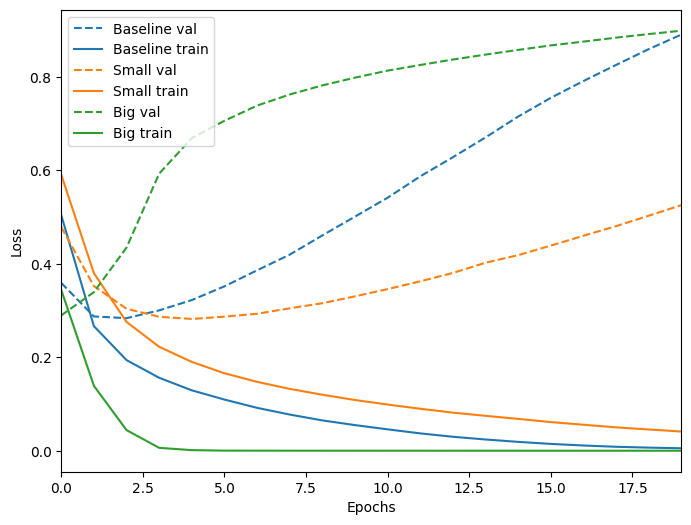

In [12]:
plt.figure(figsize=(8, 6))

# 세 개의 모델(베이스라인, 작은 모델, 큰 모델)의 손실 값 변화를 그래프로 나타냅니다.
for name, history in [('baseline', history1), ('small', history2), ('big', history3)]:
    val = plt.plot(history.epoch, history.history['val_loss'], '--', label=name.title()+' val')  # 검증 손실을 점선으로 그립니다.
    plt.plot(history.epoch, history.history['loss'], color=val[0].get_color(), label=name.title()+' train')  # 훈련 손실을 선으로 그립니다.

plt.legend()  # 범례를 추가합니다.
plt.xlabel('Epochs')  # x축 레이블을 설정합니다.
plt.ylabel('Loss')     # y축 레이블을 설정합니다.
plt.xlim([0, max(history.epoch)])  # x축의 범위를 설정합니다.

## l2 regularization 을 적용하여 같은 Test

keras.regularizers.l2(0.001)는 L2 정규화 객체의 인스턴스를 생성합니다. 여기서 0.001은 정규화 강도를 나타냅니다. L2 정규화는 가중치 감쇠(weight decay)라고도 불리며, 신경망에서 과적합을 방지하기 위해 손실 함수에 패널티 항을 추가하는 일반적으로 사용되는 기법입니다.

In [13]:
regularizer = keras.regularizers.l2(0.001)
dropout = 0.0

model_1 = make_model(16, regularizer, dropout)
model_2 = make_model(4, regularizer, dropout)
model_3 = make_model(512, regularizer, dropout)

In [14]:
history1 = model_1.fit(X_train, train_label, epochs=20, batch_size=512, validation_data=(X_test, test_label), verbose=1)
history2 = model_2.fit(X_train, train_label, epochs=20, batch_size=512, validation_data=(X_test, test_label), verbose=1)
history3 = model_3.fit(X_train, train_label, epochs=20, batch_size=512, validation_data=(X_test, test_label), verbose=1)

Epoch 1/20
49/49 [==============================] - 5s 77ms/step - loss: 0.5404 - accuracy: 0.7926 - binary_crossentropy: 0.5038 - val_loss: 0.3890 - val_accuracy: 0.8776 - val_binary_crossentropy: 0.3519
Epoch 2/20
49/49 [==============================] - 1s 21ms/step - loss: 0.3082 - accuracy: 0.9066 - binary_crossentropy: 0.2663 - val_loss: 0.3352 - val_accuracy: 0.8849 - val_binary_crossentropy: 0.2898
Epoch 3/20
49/49 [==============================] - 1s 22ms/step - loss: 0.2548 - accuracy: 0.9268 - binary_crossentropy: 0.2067 - val_loss: 0.3357 - val_accuracy: 0.8846 - val_binary_crossentropy: 0.2857
Epoch 4/20
49/49 [==============================] - 1s 21ms/step - loss: 0.2297 - accuracy: 0.9383 - binary_crossentropy: 0.1779 - val_loss: 0.3430 - val_accuracy: 0.8840 - val_binary_crossentropy: 0.2901
Epoch 5/20
49/49 [==============================] - 1s 22ms/step - loss: 0.2152 - accuracy: 0.9449 - binary_crossentropy: 0.1611 - val_loss: 0.3543 - val_accuracy: 0.8809 - val_bin

(0.0, 19.0)

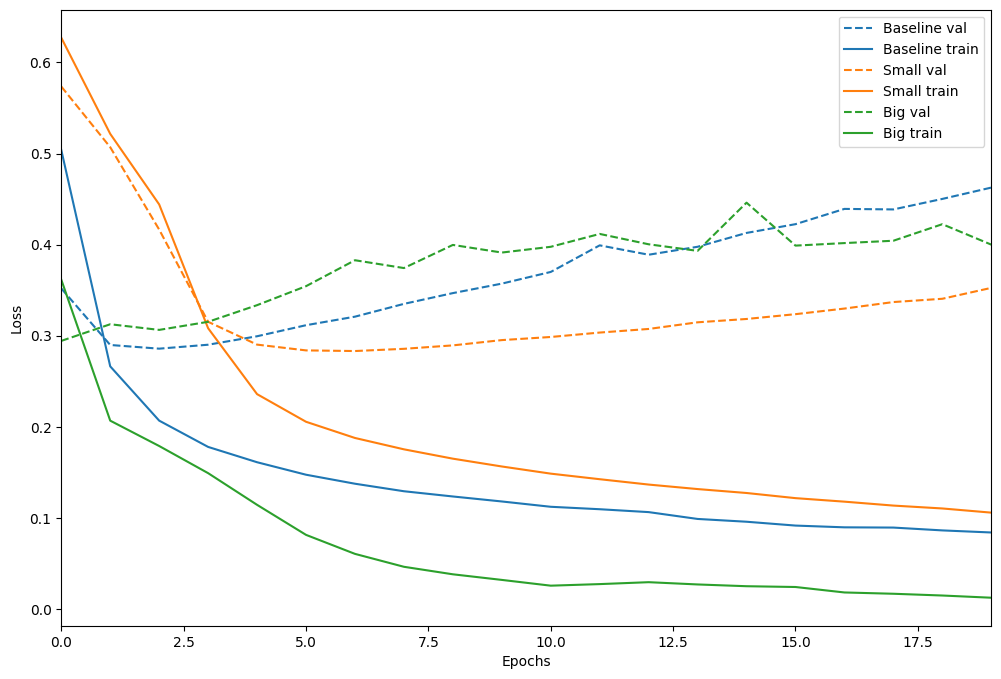

In [15]:
plt.figure(figsize=(8, 6))

for name, history in [('baseline', history1), ('small', history2), ('big', history3)]:
    val = plt.plot(history.epoch, history.history['val_binary_crossentropy'], '--', label=name.title()+' val')
    plt.plot(history.epoch, history.history['binary_crossentropy'], color=val[0].get_color(), label=name.title()+' train')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim([0, max(history.epoch)])

## Dropout 을 적용하여 같은 Test

Epoch 1/20
49/49 [==============================] - 4s 65ms/step - loss: 0.6094 - accuracy: 0.6631 - binary_crossentropy: 0.6094 - val_loss: 0.4513 - val_accuracy: 0.8555 - val_binary_crossentropy: 0.4513
Epoch 2/20
49/49 [==============================] - 1s 22ms/step - loss: 0.4259 - accuracy: 0.8277 - binary_crossentropy: 0.4259 - val_loss: 0.3224 - val_accuracy: 0.8836 - val_binary_crossentropy: 0.3224
Epoch 3/20
49/49 [==============================] - 1s 22ms/step - loss: 0.3279 - accuracy: 0.8818 - binary_crossentropy: 0.3279 - val_loss: 0.2861 - val_accuracy: 0.8829 - val_binary_crossentropy: 0.2861
Epoch 4/20
49/49 [==============================] - 1s 23ms/step - loss: 0.2677 - accuracy: 0.9079 - binary_crossentropy: 0.2677 - val_loss: 0.2777 - val_accuracy: 0.8857 - val_binary_crossentropy: 0.2777
Epoch 5/20
49/49 [==============================] - 1s 25ms/step - loss: 0.2243 - accuracy: 0.9255 - binary_crossentropy: 0.2243 - val_loss: 0.2846 - val_accuracy: 0.8867 - val_bin

(0.0, 19.0)

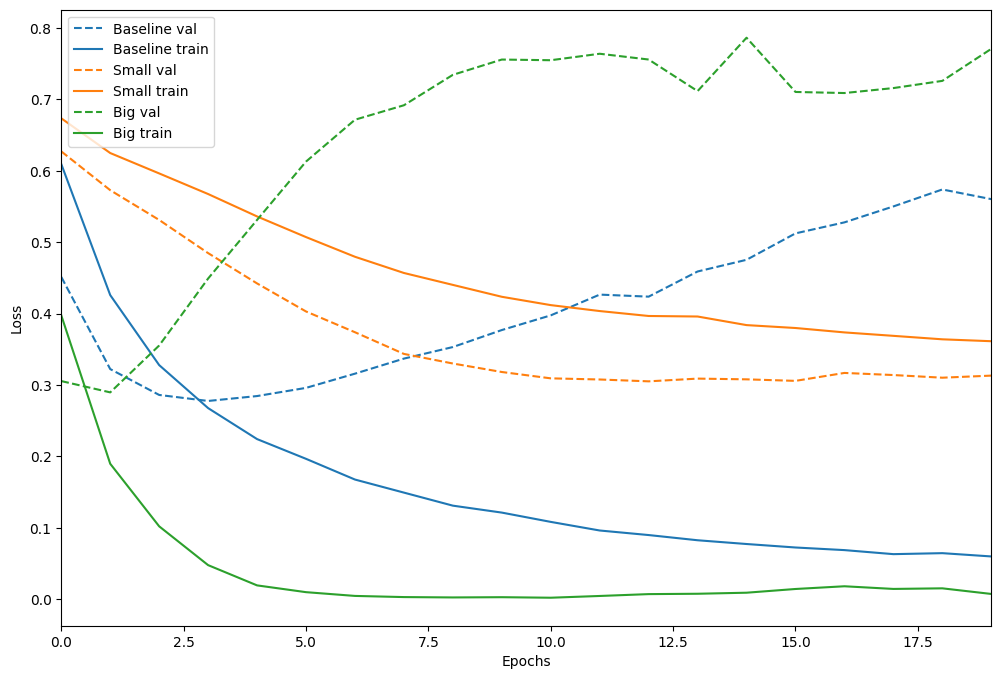

In [16]:
regularizer = None
dropout = 0.5

model_1 = make_model(16, regularizer, dropout)
model_2 = make_model(4, regularizer, dropout)
model_3 = make_model(512, regularizer, dropout)

history1 = model_1.fit(X_train, train_label, epochs=20, batch_size=512, validation_data=(X_test, test_label), verbose=1)
history2 = model_2.fit(X_train, train_label, epochs=20, batch_size=512, validation_data=(X_test, test_label), verbose=1)
history3 = model_3.fit(X_train, train_label, epochs=20, batch_size=512, validation_data=(X_test, test_label), verbose=1)

plt.figure(figsize=(8, 6))

for name, history in [('baseline', history1), ('small', history2), ('big', history3)]:
    val = plt.plot(history.epoch, history.history['val_binary_crossentropy'], '--', label=name.title()+' val')
    plt.plot(history.epoch, history.history['binary_crossentropy'], color=val[0].get_color(), label=name.title()+' train')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim([0, max(history.epoch)])